# 线性分类

## 小结:
1. 将 softmax 与 交叉熵损失函数结合使用，求出的导数估计了预测概率与真实概率的差距。  
$$
\partial_{o_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\exp(o_j)}{\sum_{k=1}^q \exp(o_k)} - y_j = \mathrm{softmax}(\mathbf{o})_j - y_j.
$$
2. 
当输出概率接近0时对应log会无限大，对梯度造成影响。因此，在实际计算时，通常忽略预测概率接近0的样本对损失函数的贡献。这可能会导致模型欠拟合，并且在训练过程中难以收敛。
```python
@base_module.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()
```

3. 
测试数据读取速度，通过num_workers调整  
```python
tic = time.time()
for X, y in data.train_dataloader():
    continue
f'{time.time() - tic:.2f} sec'
```





https://d2l.ai/chapter_linear-classification/generalization-classification.html  
机器学习理论部分:  
1. 使用函数在测试集上的误差$$\epsilon_\mathcal{D}(f) = \frac{1}{n}\sum_{i=1}^n \mathbf{1}(f(\mathbf{x}^{(i)}) \neq y^{(i)}).$$估算总体误差，
由于总体误差是1/0损失函数在总体分布上的期望，由中心极限定理可知，样本的均值的分布为以总体真实均值为中心的正态分布，以平方根的速度趋近真实值。

2. 霍夫丁不等式:
$$P(\epsilon_\mathcal{D}(f) - \epsilon(f) \geq t) < \exp\left( - 2n t^2 \right).$$  可以推算在多少置信度下达到多少误差所需样本数。

3. 测试集一旦没被用于评估过则丧失了其作为评估函数总体误差的效果。

4. 多重假设检验:  
当用同一个测试集测试多个分类器并由此选择分类器时，无法给出置信度下在需要误差范围内的结论。  




In [4]:
#  根据霍夫丁不等式计算所需样本数
import math
math.log(0.001) / (-2 * 0.0001 * 0.0001)

345387763.9491068

https://d2l.ai/chapter_linear-classification/environment-and-distribution-shift.html

深度学习领域问题:  
1. Covariate Shift  
对数据的假设是 x 决定了 y label， 即P(y|x)。  
前提是P(x)发生变化， 但P(y|x)没有发生变化， (通过隐空间解决?)  
例如训练集是照片，但测试集是卡通。  

2. Label Shift  
对数据的假设是 y 决定了 x， 即P(x|y)。

3. Concept Shift  
label 在不同领域意义不同， 即 P(y|x) 发生变化。  

解决方案：  
1. Covariate Shift  
训练一个逻辑回归器对样本重采样，添加重采样系数

2. Label Shift  
使用混淆矩阵， 对label附加权重

3. Concept Shift  
使用新样本fine-tune模型权重

1. softlabel  
softlabel 有效的原因在于 softmax 无法完全拟合 0 / 1 分布，因此提出使用softlabel 去拟合。  
2. 

In [8]:
import time
import torch
import torchvision
from torchvision import transforms
import base_module

## 1. 创建 MNIST 数据集

In [2]:
class FashionMNIST(base_module.DataModule): 
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=64, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True)

In [3]:
data = FashionMNIST(resize=(32, 32))
len(data.train), len(data.val)

(60000, 10000)

In [4]:
@base_module.add_to_class(FashionMNIST)
def text_labels(self, indices):
    """Return text labels."""
    labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
              'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [labels[int(i)] for i in indices]

In [5]:
@base_module.add_to_class(FashionMNIST)
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

In [6]:
X, y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64


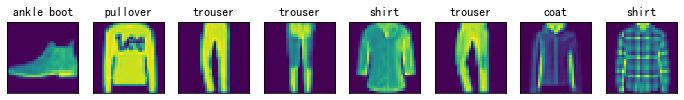

In [7]:
@base_module.add_to_class(FashionMNIST)  #@save
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
    X, y = batch
    if not labels:
        labels = self.text_labels(y)
    base_module.show_images(X.squeeze(1), nrows, ncols, titles=labels)
batch = next(iter(data.val_dataloader()))
data.visualize(batch)

## 2. 构建分类基础模型 Classifier

## 3. 编写 softmax 函数


In [69]:
def softmax(data):
    data = data - data.max(axis=1, keepdim = True).values
    exp = torch.exp(data)  # 针对过大或过小的数字会造成溢出,通过减去最大值防止上溢出
    return exp / torch.sum(exp, axis=1, keepdim=True)

In [70]:
class SoftmaxRegressionScratch(base_module.Classifier):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

In [73]:
@base_module.add_to_class(SoftmaxRegressionScratch)
def forward(self, X):
    X = X.reshape((-1, self.W.shape[0]))
    return softmax(torch.matmul(X, self.W) + self.b)

In [74]:
@base_module.add_to_class(SoftmaxRegressionScratch)
def loss(self, y_hat, y):
    return -torch.log(y_hat[list(range(len(y_hat))), y]).mean()

In [75]:
data = FashionMNIST(batch_size=512)
model = SoftmaxRegressionScratch(num_inputs=784, num_outputs=10, lr=0.1)
trainer = base_module.Trainer(max_epochs=10)


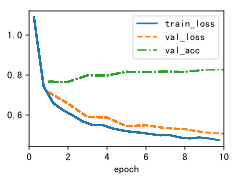

In [76]:
trainer.fit(model, data)

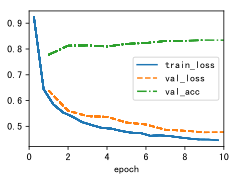

In [24]:
trainer.fit(model, data)

预测

In [25]:
X, y = next(iter(data.val_dataloader()))
preds = model(X).argmax(axis=1)
preds.shape

torch.Size([256])

绘制模型预测错误的数据

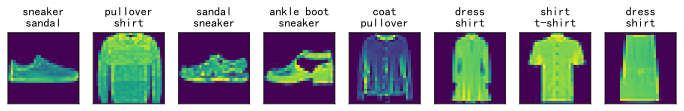

In [27]:
wrong = preds.type(y.dtype) != y
X, y, preds = X[wrong], y[wrong], preds[wrong]
labels = [a+'\n'+b for a, b in zip(
    data.text_labels(y), data.text_labels(preds))]
data.visualize([X, y], labels=labels)